see http://krex.k-state.edu/dspace/bitstream/handle/2097/9785/RahulChoubey2011.pdf

This is an implementation of the **second** method of the two described above, namely topic distance.

Extract topics from the dataset using LDA then, for each test document, find out what are the most significant topics for it. Then find out which training set documents have similar topic distributions (as measured by KL-divergence) and propagate the tags from the one most similar document.

> This is the same thing as doing kNN where k=1 and the distance measure between representations is the KL-divergence.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import re
import pickle
import sklearn
import sys
import string

from datetime import datetime
from scipy import stats

from sklearn.externals import joblib
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.topics
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics

In [5]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking

In [20]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-topics/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-13.csv')
OUTPUT_FILE = 'output-topic-distances-'+ datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.txt'

# CONFIGS

SEED= 42

MAX_NB_WORDS = 500

# for sampling
MIN_TAG_DF = 10

# CONFIGS
NB_NEIGHBOURS = 1
DISTANCE_METRIC= lambda a,b: stats.entropy(a,b)
STOP_WORDS='english' # using stopwords since most people using LDA do this
NB_COMPONENTS = [50,100,200,300]

In [21]:
np.random.seed(SEED)

In [22]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [23]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [24]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [25]:
vect = TfidfVectorizer(max_features=MAX_NB_WORDS)
vect.fit(data)

X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)

In [26]:
%%time

lda = dict()

for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    
    cache_path = INTERIM_DATA_ROOT+"/lda-NBCOMPS={}NBWORDS={}SEED={}.p".format(nb_comp,MAX_NB_WORDS,SEED)
    
    if os.path.isfile(cache_path):
        lda[nb_comp]=joblib.load(open(cache_path,"rb"))
    else:
        lda[nb_comp] = LatentDirichletAllocation(n_components=nb_comp, learning_method='online')
        lda[nb_comp].fit(X_train_vect)
        joblib.dump(lda[nb_comp],open(cache_path,"wb"))

nb_comp=50
nb_comp=100
nb_comp=200
nb_comp=300
CPU times: user 7min 43s, sys: 21min 51s, total: 29min 34s
Wall time: 4min 5s


In [30]:
def train_and_score(nb_comp):
    nbrs = NearestNeighbors(n_neighbors=NB_NEIGHBOURS, metric=DISTANCE_METRIC)
    
    lda_model = lda[nb_comp]
    
    # train
    X_train = lda_model.transform(X_train_vect)
    X_val = lda_model.transform(X_val_vect)
    
    nbrs.fit(X_train)
    
        
    Y_pred_val = []

    # distance matrix shape: (num_validation_documents, k)
    # indices matrix shape: (num_validation_documents, k)
    distances_matrix_val, indices_matrix_val = nbrs.kneighbors(X_val)
    
    neighbour_labels_tensor_val = Y_train[indices_matrix_val]    
   
    # for every validation document do
    for i in range(distances_matrix_val.shape[0]):
        # these are the labels from the neighbours of test document i
        # shape: (k, num_tags)
        neighbor_labels = neighbour_labels_tensor_val[i,:,:]
        
        # these are the distances from test document i to the nearest neighbours
        # shape: (k, )
        distances_to_neighbors = distances_matrix_val[i]

        # sum the contributions from all neighbors, for all tags
        # no need to normalize because we're only interested in the order
        y_preds = neighbor_labels.sum(axis=0)
                    
        Y_pred_val.append(y_preds)

    Y_pred_val = np.array(Y_pred_val)
            
    ks = [1,2,3,4,5,6,7,8,9,10]
    
    # k is the number of neighbors so let's use at_k
    for at_k in ks:
        print("validation micro-F1 @{}: {}".format(at_k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True))) 

    print('')  

In [33]:
for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    train_and_score(nb_comp)

nb_comp=50
validation micro-F1 @1: 0.05415860735009671
validation micro-F1 @2: 0.051331719128329296
validation micro-F1 @3: 0.0491273432449903
validation micro-F1 @4: 0.04422843256379101
validation micro-F1 @5: 0.03860401637746149
validation micro-F1 @6: 0.03739229393594538
validation micro-F1 @7: 0.03570432357043236
validation micro-F1 @8: 0.033475870494807575
validation micro-F1 @9: 0.032380745409105724
validation micro-F1 @10: 0.03092581718535917

nb_comp=100
validation micro-F1 @1: 0.05227492739593417
validation micro-F1 @2: 0.055099081681971966
validation micro-F1 @3: 0.051646223369916075
validation micro-F1 @4: 0.04470359572400389
validation micro-F1 @5: 0.039368544143441826
validation micro-F1 @6: 0.038349041273968154
validation micro-F1 @7: 0.036525860867140665
validation micro-F1 @8: 0.034436439125656367
validation micro-F1 @9: 0.03344917463075586
validation micro-F1 @10: 0.03227383863080684

nb_comp=200
validation micro-F1 @1: 0.07464114832535886
validation micro-F1 @2: 0.065

In [40]:
feats_50 = [
 0.05415860735009671, 0.051331719128329296,
0.0491273432449903,0.04422843256379101,
0.03860401637746149, 0.03739229393594538,
0.03570432357043236, 0.033475870494807575, 0.032380745409105724, 0.03092581718535917    
]

feats_100 = [
 0.05227492739593417, 0.055099081681971966,
 0.051646223369916075, 0.04470359572400389,
 0.039368544143441826, 0.038349041273968154,
0.036525860867140665,
     0.034436439125656367,
 0.03344917463075586,
 0.03227383863080684,    
]

feats_200 = [
0.07464114832535886,
0.06538461538461539,
0.05728999034438365,
0.052746189208807165,
0.047739181059576946,
0.045969569439948205,
0.044160533259269545,
0.04161090156953401,
0.041743268086947116,
0.0395595829679431  
]

feats_300 = [
0.07279693486590039,
0.06165703275529865,
0.05415860735009671,
0.05085977234197142,
0.04736024844720497,
0.045020242914979754,
0.04171301446051168,
0.03826934795856185,
0.03749864528015606,
0.03573171922288392
]


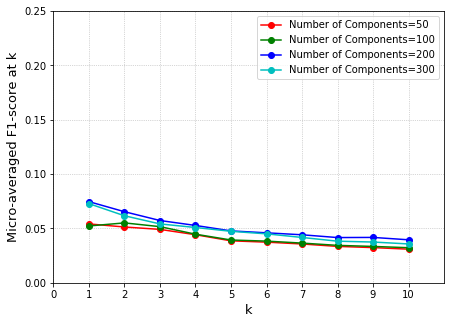

In [42]:
plt.clf()
ax = plt.gca()

ks = range(1, 11)

ax.plot(ks, feats_50, 'ro-', label='Number of Components=50')

ax.plot(ks, feats_100, 'go-', label='Number of Components=100')

ax.plot(ks, feats_200, 'bo-', label='Number of Components=200')

ax.plot(ks, feats_300, 'co-', label='Number of Components=300')

ax.set_xlim(0, 11)
ax.set_ylim(0, 0.25)
ax.set_xlabel('k', fontsize=13)

ax.set_ylabel('Micro-averaged F1-score at k', fontsize=13)

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 0.26, 0.05))
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)
plt.gcf().set_size_inches(7,5)
ax.legend()
plt.show()